<a href="https://colab.research.google.com/github/uesmgn/classification-vae/blob/master/notebook_cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

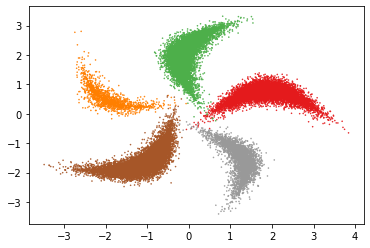

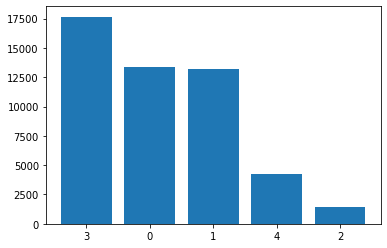

---------- epoch: 1 ----------
loss: 610.520
nmi: 0.491
---------- epoch: 2 ----------
loss: 319.903
nmi: 0.750
---------- epoch: 3 ----------
loss: 173.090
nmi: 0.940
---------- epoch: 4 ----------
loss: 140.774
nmi: 0.940
---------- epoch: 5 ----------
loss: 126.505
nmi: 0.941


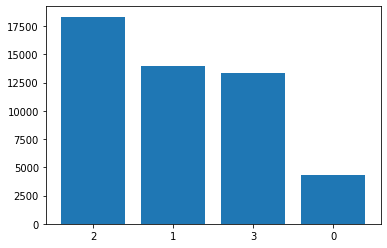

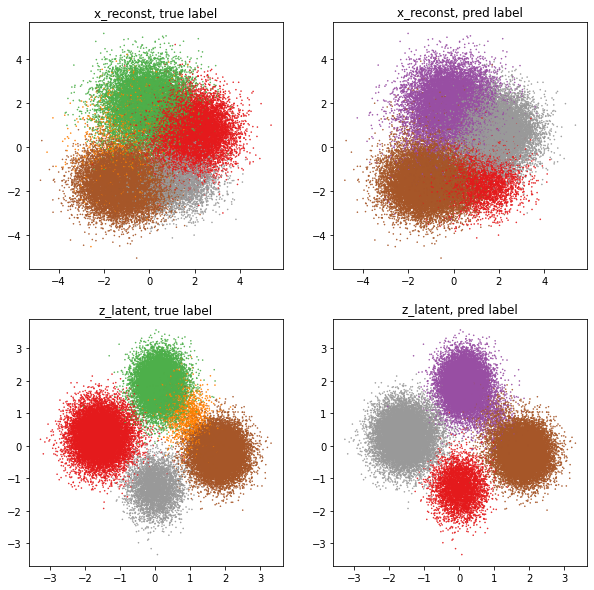

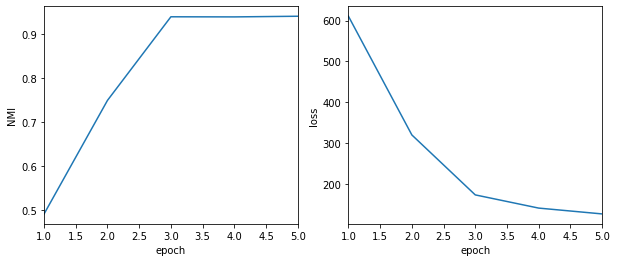

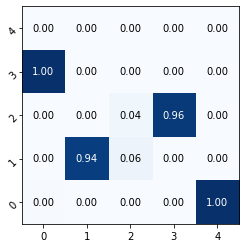

---------- epoch: 6 ----------
loss: 120.082
nmi: 0.942
---------- epoch: 7 ----------
loss: 111.969
nmi: 0.977
---------- epoch: 8 ----------
loss: 104.194
nmi: 0.989
---------- epoch: 9 ----------
loss: 98.321
nmi: 0.988
---------- epoch: 10 ----------
loss: 95.323
nmi: 0.990


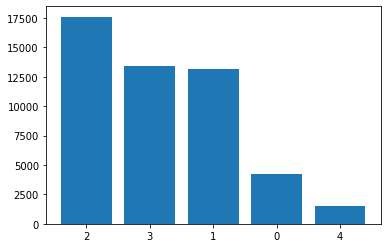

In [ ]:
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing

eps = 1e-10


def make_spiral_moons(n_samples=10000, k=5, noise=0.1, imbalance=True, padding=0.3, random_state=None):
    np.random.seed(random_state)

    x_stack = np.array([])
    y_stack = np.array([])
    labels = np.array([], dtype=np.int)

    if imbalance:
        sizes = _random_split(n_samples, k, random_state=random_state)
    else:
        eps = np.append(np.ones(n_samples % k), np.zeros(k - n_samples % k))
        eps = np.random.permutation(eps).astype(np.int)
        sizes = [n_samples // k + eps[i] for i in range(k - 1)]
        sizes.append(n_samples - np.sum(sizes))
    for i in range(k):
        size = sizes[i]
        x = np.random.normal(loc=np.pi / 2 + padding, scale=0.5, size=size)
        sin_gauss = np.sin(np.linspace(0, np.pi, size)) * \
            (np.random.normal(loc=0, scale=noise, size=size))
        y = np.sin(x - padding) - .2 + sin_gauss
        theta = 2 * np.pi * i / k
        x_ = np.cos(theta) * x - np.sin(theta) * y
        y_ = np.sin(theta) * x + np.cos(theta) * y
        label = (np.ones(len(x_)) * i).astype(np.int)
        x_stack = np.append(x_stack, x_)
        y_stack = np.append(y_stack, y_)
        labels = np.append(labels, label)
    x_stack = np.ravel(x_stack)
    y_stack = np.ravel(y_stack)
    labels = np.ravel(labels)
    return x_stack, y_stack, labels


def _random_split(n_samples, k, random_state=None):
    np.random.seed(random_state)
    div = np.random.choice(list(range(1, n_samples - 1)),
                           k - 1, replace=False).astype(np.int)
    div = np.sort(div)
    div = np.append(div, n_samples)
    ret = []
    x = 0
    for i in range(k):
        x_ = div[i] - x
        ret.append(x_)
        x = div[i]
    return ret


def reparameterization_trick(mean, var):
    if torch.is_tensor(var):
        std = torch.pow(var, 0.5)
    elif isinstance(var, float):
        std = np.sqrt(var)
    else:
        raise ValueError('variance must be tensor or float.')
    e = torch.randn_like(mean)
    x = mean + std * e
    return x


class Gaussian(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(in_dim, out_dim * 2)
        )

    def forward(self, x, var=None):
        x = self.features(x)
        mean, logits = torch.split(x, x.shape[-1] // 2, -1)
        var = var or F.softplus(logits) + eps
        x = reparameterization_trick(mean, var)
        return x, mean, var


class GumbelSoftmax(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x, tau=1., dim=-1, hard=False):
        logits = self.features(x)
        pi = logits.softmax(dim)
        gumbels = -torch.empty_like(logits).exponential_().log()
        gumbels = (logits + gumbels) / tau
        y = gumbels.softmax(dim)

        if hard:
            index = y.max(dim, keepdim=True)[1]
            y_hard = torch.zeros_like(logits).scatter_(dim, index, 1.0)
            y = y_hard - y.detach() + y

        return y, pi


class CVAE(nn.Module):
    def __init__(self, x_dim, y_dim, z_dim, **kwargs):
        super().__init__()
        f_dim = kwargs.get('f_dim') or 32

        # Encoder
        self.zy_x_graph = nn.Sequential(
            nn.Linear(x_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, f_dim),
            nn.ReLU(inplace=True)
        )
        self.y_x_graph = GumbelSoftmax(f_dim, y_dim)
        self.z_xy_graph = Gaussian(f_dim + y_dim, z_dim)

        # Decoder
        self.z_y_graph = Gaussian(y_dim, z_dim)

        self.x_z_graph = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            Gaussian(64, x_dim)
        )

        for m in self.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_normal_(m.weight)
                if m.bias.data is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        h = self.zy_x_graph(x)
        y_x, y_x_pi = self.y_x_graph(h)
        y_pred = y_x_pi.max(-1, keepdim=True)[1]
        xy_cat = torch.cat((h, y_x), dim=-1)
        z_xy, z_xy_mean, z_xy_var = self.z_xy_graph(xy_cat)
        z_y, z_y_mean, z_y_var = self.z_y_graph(y_x)
        x_z, x_z_mean, x_z_var = self.x_z_graph(z_xy)

        return {'x': x,
                'x_z': x_z, 'x_z_mean': x_z_mean, 'x_z_var': x_z_var,
                'z_xy': z_xy, 'z_xy_mean': z_xy_mean, 'z_xy_var': z_xy_var,
                'z_y': z_y, 'z_y_mean': z_y_mean, 'z_y_var': z_y_var,
                'y_x': y_x, 'y_x_pi': y_x_pi, 'y_pred': y_pred}


def criterion(params, beta=(1.0, 1.0, 1.0)):
    rec_loss = beta[0] * mse_loss(params['x'], params['x_z_mean']).view(-1)
    z_kl = beta[1] * log_norm_kl(
        params['z_xy'], params['z_xy_mean'], params['z_xy_var'],
        params['z_y_mean'], params['z_y_var']).view(-1)
    y_kl = beta[2] * uniform_categorical_kl(params['y_x']).view(-1)
    return torch.cat((rec_loss, z_kl, y_kl))


def mse_loss(inputs, targets, reduction='mean'):
    loss = F.mse_loss(inputs, targets).sum(-1)
    return reduce(loss, reduction)


def log_norm_kl(x, mean, var, mean_, var_, reduction='mean'):
    log_p = -0.5 * (torch.log(2.0 * np.pi * var) +
                    torch.pow(x - mean, 2) / var).sum(-1)
    log_q = -0.5 * (torch.log(2.0 * np.pi * var_) +
                    torch.pow(x - mean_, 2) / var_).sum(-1)
    loss = log_p - log_q
    return reduce(loss, reduction)


def uniform_categorical_kl(y, reduction='mean'):
    k = y.shape[-1]
    u = torch.ones_like(y) / k
    kl = (u * torch.log(u / y + eps)).sum(-1)
    return reduce(kl, reduction)


def reduce(target, reduction):
    if reduction is 'mean':
        return target.mean()
    if reduction is 'sum':
        return target.sum()
    return target

def confusion_matrix(true, pred, labels_true, labels_pred,
                     normalize=True, return_labels=False):
    matrix = np.zeros([len(labels_true), len(labels_pred)])
    for (t, p) in itertools.product(labels_true, labels_pred):
        idx = np.where(pred[np.where(true==t)]==p)[0]
        matrix[list(labels_true).index(t),
               list(labels_pred).index(p)] += len(idx)
    if normalize:
        matrix = preprocessing.normalize(matrix, axis=0, norm='l1')
    if return_labels:
        return matrix, labels_true, labels_pred
    return matrix

def plot_confusion_matrix(cm, xlabels, ylabels):
    cmap = plt.get_cmap('Blues')
    plt.imshow(cm.T, interpolation='nearest',
               cmap=plt.get_cmap('Blues'),
               origin='lower')
    ax = plt.gca()
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(len(xlabels)), range(len(ylabels))):
        num = "{:0.2f}".format(cm[i, j])
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(i, j, num, fontsize=10, color=color, ha='center', va='center')
    plt.show()

cmap = 'Set1'
x_dim = 2
y_dim = 5
z_dim = 2
f_dim = 32
lr = 0.001

x, y, trues = make_spiral_moons(
    n_samples=50000, k=5, noise=0.2, imbalance=True)

plt.scatter(x, y, c=trues, cmap=cmap, s=0.3)
plt.show()

counter = np.array([[label, np.count_nonzero(np.array(trues) == label)]
                    for label in list(set(trues))])
idx = np.argsort(counter[:, 1])[::-1]
x_position = np.arange(len(counter[:, 0]))
plt.bar(x_position, counter[:, 1][idx], tick_label=counter[:, 0][idx])
plt.show()

device = f'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

transform = transforms.ToTensor()
model = CVAE(x_dim, y_dim, z_dim, f_dim=f_dim)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

data = np.array([x, y]).T
X = transform(data.astype(np.float32)).transpose(0, 1)
Y = transform(np.expand_dims(trues, axis=0)).transpose(0, 2)

dataset = torch.utils.data.TensorDataset(X, Y)
loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=100,
                                     shuffle=True)

labels_true = sorted(list(set(trues)))
labels_pred = sorted(list(range(y_dim)))

def train(beta, n_epoch=30, plt_itvl=5):
    nmi_stats = []
    loss_stats = []
    for e in range(1, n_epoch + 1):
        out_z = torch.Tensor([]).to(device)
        out_x = torch.Tensor([]).to(device)
        trues = np.array([])
        preds = np.array([], dtype=np.int)
        total = 0
        for _, (x, l) in enumerate(loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_ = model(x)
            losses = criterion(x_, beta)
            loss = losses.sum()
            loss.backward()
            optimizer.step()

            out_z = torch.cat([out_z, x_['z_xy']], 0)
            out_x = torch.cat([out_x, x_['x_z']], 0)
            trues = np.append(trues, np.ravel(l))
            preds = np.append(
                preds, x_['y_pred'].view(-1).detach().cpu().numpy().astype(np.int))
            total += loss.item()
        nmi = metrics.adjusted_mutual_info_score(trues, preds)
        nmi_stats.append(nmi)
        loss_stats.append(total)

        print(f'---------- epoch: {e} ----------')
        print(f'loss: {total:.3f}')
        print(f'nmi: {nmi:.3f}')

        if e % plt_itvl == 0:
            out_z = out_z.squeeze(1).detach().cpu().numpy()
            out_x = out_x.squeeze(1).detach().cpu().numpy()

            cm = confusion_matrix(trues, preds, labels_true, labels_pred)

            counter = np.array([[label, np.count_nonzero(
                np.array(preds) == label)] for label in list(set(preds))])
            idx = np.argsort(counter[:, 1])[::-1]
            x_position = np.arange(len(counter[:, 0]))
            plt.bar(x_position, counter[:, 1][idx],
                    tick_label=counter[:, 0][idx])
            plt.show()

            fig, axs = plt.subplots(2, 2, figsize=(10, 10))

            ax = axs[0, 0]
            ax.scatter(out_x[:, 0], out_x[:, 1], c=trues, cmap=cmap, s=0.3)
            ax.set_title('x_reconst, true label')

            ax = axs[0, 1]
            ax.scatter(out_x[:, 0], out_x[:, 1], c=preds, cmap=cmap, s=0.3)
            ax.set_title('x_reconst, pred label')

            ax = axs[1, 0]
            ax.scatter(out_z[:, 0], out_z[:, 1], c=trues, cmap=cmap, s=0.3)
            ax.set_title('z_latent, true label')

            ax = axs[1, 1]
            ax.scatter(out_z[:, 0], out_z[:, 1], c=preds, cmap=cmap, s=0.3)
            ax.set_title('z_latent, pred label')

            plt.show()
        
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            xx = np.array(range(e)) + 1
            xlim = (min(xx), max(xx))
            
            ax = axs[0]
            ax.plot(xx, nmi_stats)
            ax.set_xlim(xlim)
            ax.set_xlabel('epoch')
            ax.set_ylabel('NMI')        

            ax = axs[1]
            ax.plot(xx, loss_stats)
            ax.set_xlim(xlim)
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            
            plt.show()

            plot_confusion_matrix(cm, labels_true, labels_pred)

beta = (1., 0.91, 2.2e-5)
train(beta)
